In [1]:
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import scipy as sp
from scipy import stats, special

In [4]:
from algorithms import HMC, SGLD, SGHMC
from experiments.pca.helpers import loggamma_logpdf, vectorize_params, unvectorize_params
from experiments.pca.bpca import BPCA

In [5]:
N = 300
# hyperparameters
shape_alpha = 0.7 # keep this small to flatten distribution
scale_alpha = 4.0
beta = 0.5
shape_tau = 0.7
scale_tau = 1.0

# N, d would be derived from dataset not other way round
d = 10
q = d-1

stochastic_batch_size = 30

In [6]:
mu = np.random.multivariate_normal(np.zeros(d), np.identity(d) / beta).reshape((d,))
alpha = np.log(np.random.gamma(shape_alpha, scale_alpha, size=(q,)))
W = np.random.multivariate_normal(
    np.zeros((d, q)).ravel(), 
    np.kron(np.identity(d), np.identity(q) * 1/np.exp(alpha))).reshape((d,q))
tau = np.log(np.random.gamma(shape_tau, scale_tau))
params = np.concatenate((
        W.ravel(), mu, np.array(tau).reshape(1,), alpha))

cov = np.diag(np.array([10,6,6,3,1,1,1,1,1,1])**2)
data = np.random.multivariate_normal(np.zeros(d), cov, size=N)

In [7]:
# Init BPCA
bpca = BPCA(shape_alpha=shape_alpha, scale_alpha=scale_alpha, beta=beta, shape_tau=shape_tau,
            scale_tau=scale_tau)
bpca.setup(data, q)

print('alpha log prior', bpca.log_prior_alpha(alpha))
print('tau log prior', bpca.log_prior_tau(tau))
print('W log prior', bpca.log_prior_W(W, alpha))
print('mu log prior', bpca.log_prior_mu(mu))
print('potential energy', bpca.potential_energy(data, W, mu, tau, alpha))


alpha log prior -14.26269149411923
tau log prior -1.594335597666158
W log prior 12.880170226152712
mu log prior -25.44839099626499
potential energy 10423.389303844988


In [8]:
np.exp(tau)

0.19728137999420495

In [9]:
np.exp(alpha)

array([7.37722, 6.17137, 0.83575, 0.33579, 2.98218, 0.37347, 2.40275,
       3.35711, 7.98814])

## Samplers

In [10]:
its = 50000
stochastic_batch_size = 30
# Note (N / batch_size) should divide runs to ensure data is seen equally

#### HMC Setup

In [ ]:
hmc_sampler = HMC(potential_grad=bpca.vectorized_grad_U, mass=np.identity(params.shape[0]), 
        step_size=0.005, step_count=3)

In [ ]:
hmc_mh_sampler = HMC(potential_grad=bpca.vectorized_grad_U, mass=np.identity(params.shape[0]), 
        step_size=0.005, step_count=3, potential_energy=bpca.vectorized_U)

#### SGLD Setup

In [11]:
# sgld_it = int(runs * (N / batch_size))
gamma = 0.55
eps_0 = 0.01
eps_n = 0.0005
b = its / (np.exp(np.log(eps_0 / eps_n) / gamma) - 1)
a = eps_0 / b ** (-gamma)

eps_t = lambda t: a * (b + t) ** (-gamma)

sgld_sampler = SGLD(potential_grad=bpca.vectorized_grad_U, step_size=eps_t)

#### SGHMC Setups

All with decaying step size 0.01 -> 0.0005
- 3 steps
- 10 steps
- 3 steps (no resampling)
- 10 steps (no resampling)

In [12]:
def run_sghmc(start_params, its, resample_momentum=True, **sampler_kwargs):
    sampler = SGHMC(
        potential_grad=bpca.vectorized_grad_U, 
        mass=np.eye(params.size),
        friction_term=np.eye(params.size),
        **sampler_kwargs)
    bpca.reset_sampler(batch_size=stochastic_batch_size)
    trace = bpca.run(sampler=sampler, 
                     iterations=its, 
                     start_params=start_params, 
                     resample_momentum=resample_momentum)
    return trace
    

In [13]:
sghmc_params = [
    {'step_count':3, 'resample_momentum': True, 'step_size': eps_t},
    {'step_count':10, 'resample_momentum': True, 'step_size': eps_t},
    {'step_count':3, 'resample_momentum': False, 'step_size': eps_t},
    {'step_count':10, 'resample_momentum': False, 'step_size': eps_t},
]
sghmc_labels = [
    'SGHMC 3 steps', 'SGHMC 10 steps', 
    'SGHMC 3 steps, no resample', 'SGHMC 10 steps, no resample']


In [14]:
sghmc_traces = [run_sghmc(params, its, **sp) for sp in sghmc_params]

100%|██████████| 50000/50000 [06:18<00:00, 132.09it/s]


In [15]:
bpca.reset_sampler(batch_size=stochastic_batch_size)
sgld_trace = bpca.run(sampler=sgld_sampler, iterations=its, start_params=params)

100%|██████████| 50000/50000 [00:36<00:00, 1385.67it/s]


In [ ]:
bpca.reset_sampler(batch_size=N)
hmc_trace = bpca.run(sampler=hmc_sampler, iterations=its, start_params=params)

In [ ]:
bpca.reset_sampler(batch_size=N)
hmc_mh_trace = bpca.run(sampler=hmc_mh_sampler, iterations=its, start_params=params)

## Results

In [16]:
def mean_samples(samples, burn_in=1000):
    Ws = np.array([s[0] for s in samples[burn_in:]])
    mean_w = Ws.mean(axis=0)
    mus = np.array([s[1] for s in samples[burn_in:]])
    mean_mu = np.mean(mus, axis=0)
    taus = np.array([np.exp(s[2]) for s in samples[burn_in:]])
    mean_tau = taus.mean(axis=0)
    alphas = np.array([np.exp(s[3]) for s in samples[burn_in:]])
    mean_alpha = np.mean(alphas, axis=0)
    return mean_w, mean_mu, mean_tau, mean_alpha

def unvectorize_trace(trace):
    return list(map(lambda s: unvectorize_params(s, N, d, q), trace))

def log_likelihoods(samples):
    return list(map(lambda p: bpca.log_likelihood(data, *p), tqdm(samples)))

def effective_dims(alpha):
    sum_alpha = np.sum(1 / alpha)
    return np.array([i for i, inv_alpha in enumerate(1/alpha) 
                     if inv_alpha > sum_alpha / q])

def fitted_cov(W, tau, alpha, ed=None):
    if ed is None:
        ed = effective_dims(alpha)
    ed_W = W[:, ed]
    return np.eye(d) / tau + ed_W @ ed_W.T


In [17]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [18]:
def summarise(trace, burn_in=1000):
    samples = unvectorize_trace(trace)
    means = mean_samples(samples, burn_in)
    taus = [np.exp(s[2]) for s in samples]
    alphas = [np.exp(s[3]) for s in samples]
    cov = fitted_cov(W=means[0], tau=means[2], alpha=means[3])
    ed = effective_dims(means[3])
    return samples, means, taus, alphas, cov, ed

In [19]:
burn_in = 1000

In [ ]:
(hmc_samples, hmc_means, hmc_taus, 
 hmc_alphas, hmc_cov, hmc_ed) = summarise(hmc_trace, burn_in=burn_in)

print('HMC ed:', hmc_ed)
print('HMC tau:', hmc_means[2])
print('HMC alpha:', hmc_means[3])

In [ ]:
(hmc_mh_samples, hmc_mh_means, hmc_mh_taus, 
 hmc_mh_alphas, hmc_mh_cov, hmc_mh_ed) = summarise(hmc_mh_trace, burn_in=burn_in)

print('HMC MH ed:', hmc_ed)
print('HMC MH tau:', hmc_means[2])
print('HMC MH alpha:', hmc_means[3])

In [20]:
(sgld_samples, sgld_means, sgld_taus, sgld_alphas,
 sgld_cov, sgld_ed) = summarise(sgld_trace, burn_in=burn_in)

print('SGLD ed:', sgld_ed)
print('SGLD tau:', sgld_means[2])
print('SGLD alpha:', sgld_means[3])

SGLD ed: [1 5 6 8]
SGLD tau: 1.100532523989444
SGLD alpha: [ 8.26865  0.18021  9.8446   7.88381 12.23373  0.23842  0.30375 11.16062
  0.5829 ]


In [21]:
sghmc_results = list(map(lambda tr: summarise(tr, burn_in=burn_in), sghmc_traces))

In [22]:
# print('HMC Frobenius Error:', np.linalg.norm(cov - hmc_cov))
# print('HMC + MH Frobenius Error:', np.linalg.norm(cov - hmc_mh_cov))
print('SGLD Frobenius Error:', np.linalg.norm(cov - sgld_cov))

for i, res in enumerate(sghmc_results):
    print('SGHMC',i,'Frobenius Error:', np.linalg.norm(cov - res[4]))

SGLD Frobenius Error: 17.404518064089732
SGHMC 0 Frobenius Error: 39.36747964897931
SGHMC 1 Frobenius Error: 24.207994460701954
SGHMC 2 Frobenius Error: 15.349357984533395
SGHMC 3 Frobenius Error: 16.424855151096367


In [23]:
def plot_mat(cov, title, pos=111):
    plt.subplot(pos)
    plt.axis('off')
    plt.imshow(cov)
    plt.title(title, fontsize=20)

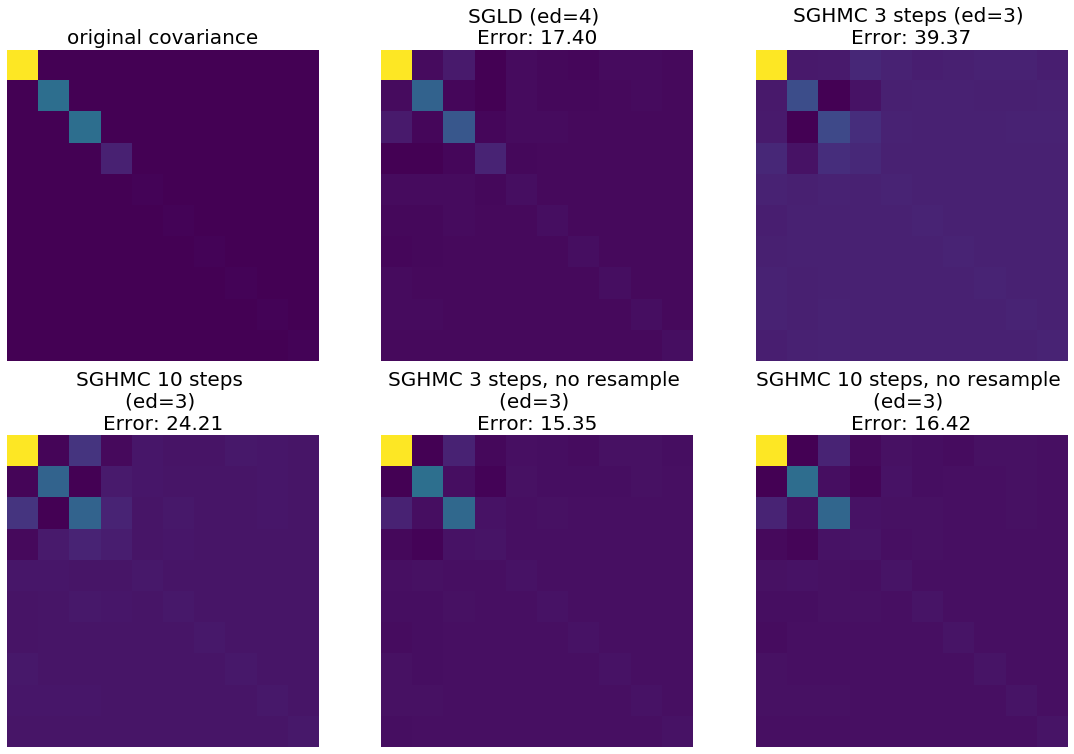

In [31]:
plt.figure(figsize=(19,13))
plot_mat(cov, 'original covariance', 231)
plot_mat(sgld_cov, 'SGLD (ed={}) \nError: {:.2f}'.format(sgld_ed.size, np.linalg.norm(cov - sgld_cov)), 232)

label_top_str = '{} (ed={}) \nError: {:.2f}'
label_bot_str = '{} \n(ed={}) \nError: {:.2f}'
for i, res in enumerate(sghmc_results):
    label = label_bot_str if i else label_top_str
    error = np.linalg.norm(cov - res[4])
    plot_mat(res[4], label.format(sghmc_labels[i], res[5].size, error), 233+i)
plt.savefig('ablation_matrices.png', dpi=200)

In [ ]:
hmc_lls = log_likelihoods(hmc_samples)

In [ ]:
hmc_mh_lls = log_likelihoods(hmc_mh_samples)

In [25]:
sgld_lls = log_likelihoods(sgld_samples)

100%|██████████| 50001/50001 [01:26<00:00, 577.51it/s]


In [26]:
sghmc_lls = list(map(lambda res: log_likelihoods(res[0]), sghmc_results))

100%|██████████| 50001/50001 [01:29<00:00, 560.03it/s]


/Users/laurencewatts/Documents/Oxford/PartC/AdvancedML/OxML-Group1/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/laurencewatts/Documents/Oxford/PartC/AdvancedML/OxML-Group1/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


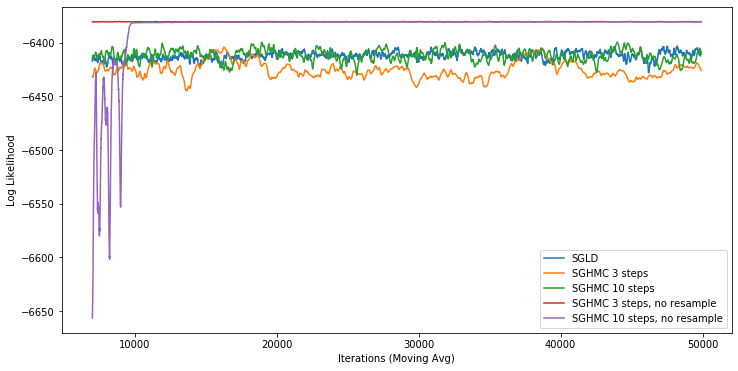

In [49]:
cut_off = 7000
until = 50000
ma = 100

plt.figure(figsize=(12,6))
xs = list(range(cut_off,until-ma+1))
plt.plot(xs, moving_average(sgld_lls[cut_off:until], n=ma), label='SGLD')

for i, sll in enumerate(sghmc_lls):
    plt.plot(xs, moving_average(sll[cut_off:until], n=ma), label=sghmc_labels[i])
    
# plt.plot(moving_average(hmc_lls[cut_off:], n=ma), label='HMC')
# plt.plot(moving_average(hmc_mh_lls[cut_off:], n=ma), label='HMC+MH')
plt.ylabel('Log Likelihood')
plt.xlabel('Iterations (Moving Avg)')
plt.legend()
plt.savefig('sghmc_comp_7k_50k_ma100.png', dpi=200)
plt.show()

In [ ]:
# Rolling cov mean matrix with frob error plot?
def rolling_cov_error(samples, burn_in=1000):
    Ws = np.array([s[0] for s in samples[burn_in:]])
    taus = np.array([np.exp(s[2]) for s in samples[burn_in:]])
    alphas = np.array([np.exp(s[3]) for s in samples[burn_in:]])
    errors = []
    for i in tqdm(range(1,Ws.shape[0]+1)):
        W = Ws[:i].mean(axis=0)
        tau = taus[:i].mean(axis=0)
        alpha = alphas[:i].mean(axis=0)
        fit_cov = fitted_cov(W, tau, alpha)
        errors.append(np.linalg.norm(cov - fit_cov))
    return errors

hmc_cov_errors = rolling_cov_error(hmc_samples, burn_in)
hmc_mh_cov_errors = rolling_cov_error(hmc_mh_samples, burn_in)
sgld_cov_errors = rolling_cov_error(sgld_samples, burn_in)
sghmc_cov_errors = rolling_cov_error(sghmc_samples, burn_in)

In [ ]:
cut = 3000

# plt.plot(hmc_cov_errors[cut:])
N = len(hmc_mh_cov_errors[cut:])
xs = list(range(cut, N+cut))
plt.figure(figsize=(10,6))
plt.plot(xs, hmc_mh_cov_errors[cut:], label='HMC+MH')
plt.plot(xs, sgld_cov_errors[cut:], label='SGLD')
plt.plot(xs, sghmc_cov_errors[cut:], label='SGHMC')
plt.legend()
plt.ylabel('Frobenius Norm Error')
plt.savefig('frob_error.png', dpi=200)
files.download('frob_error.png')
plt.show()